# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

Besides, I am using a progress bar. It has to be installed through the terminal by executing the following command:
```
pip install progressbar2
```

<b> NAVIGATION</b>


I. [Assessing and Cleaning Data](Assessing_and_Cleaning_Data)
- [Portfolio Data Set](#Portfolio_Data_Set)
- [Profile Data Set](#Profile_Data_Set)
- [Transcript Data Set](#Transcript_Data_Set)
- [Merge and Save Data Sets](#Merge_Data_Sets)

II. [Exploring with visuals](#Exploring_with_visuals)


- [Amount](#Amount)
- [Demographic](#Demographic)

III. [Feature Engineering](#Feature_Engineering)

IV. [Modelling](#Modelling)
- [Linear SVC](#LinearSVC)
- [KNeighbors Classifier](#KNeighbors)
- [Random Forest Classifier](#RandomForestClassifier)
- [Decision Tree Regressor](#DecisionTreeRegressor)

   Improvement
  
   Validation
   
   
V. [Collaborative Filtering Recomendation](#Collaborative_Filtering) 

VI. [Conclusion](#Conclusion) 



In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar
import time
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder


import time
import collections
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<a id=’Problem_Formulation’></a>
## Problem Formulation 


Instead of randomly sending offers to customers, a business can use a more targeted approach and distribute promotions to a more responsive group. 

Each customer can be given a recommendation, based on their demographic information and based on collected data of previous transactions form similar customers.

The example of a solution to this problem could be you collect and input necessary data: 

Input: Customer age: 64, gender: M, income: $64000, length of membership: 18 months


After entering this information, the classifier predicts more useful offers for this customer.

Output: Offer1, Offer4 

<a id=’Assessing_and_Cleaning_Data’></a>
## Assessing and Cleaning Data
Firstly, lets print first lines and size of our data sets.

In [3]:
#print first few lines of datasets
print("Portfolio Data Set")
portfolio.head()

Portfolio Data Set


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print("Profile Data Set")
profile.head()

Profile Data Set


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
print("Transcript Data Set")
transcript.head()

Transcript Data Set


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
print("Portfolio Data Set")
portfolio.info()
print("="*40)
print("Profile Data Set")
profile.info()
print("="*40)
print("Transcript Data Set")
transcript.info()

Portfolio Data Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
Profile Data Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usag

<a id='Portfolio_Data_Set'></a>
### Portfolio Data Set

Portfolio data set contains 10 rows and 6 columns. The set has no missing values or duplicated rows.


<b>Preprocessing steps: </b>
- Rename "id" column to "offer_id". There are several columns with "id" in our three data sets, to be able to identify and later merge all three data set we need to identify the columns to their content.
- To perform on-hot encoding of "reward" and "channels" columns
- Delete "web_channel" and "email_channel columns" as they all have the same values in all rows.



In [7]:
# change name of column
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Next, we need to split multilable cathegorical columns into dammy variables 

In [8]:
# create dummy variables for offer types
portfolio = pd.get_dummies(portfolio, columns=['offer_type'])

In [9]:
distr_channels = ['web_channel', 'email_channel', 'mobile_channel', 'social_channel']
portfolio[distr_channels] = pd.DataFrame(portfolio.channels.tolist(),
                                         index= portfolio.index)
portfolio.drop('channels', 1, inplace = True)
for col in distr_channels:
    portfolio[col]=portfolio[col].apply(lambda x: 1 if type(x)== str else 0)

In [10]:
portfolio

,reward,difficulty,duration,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,web_channel,email_channel,mobile_channel,social_channel
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,1,0


"web_channel" and "email_channel" contain only 1's , so we can elliminate them.

In [11]:
# delete columns
portfolio.drop(["web_channel","email_channel" ], 1, inplace = True)

In [12]:
portfolio.head()

,reward,difficulty,duration,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,0


<a id='Profile_Data_Set'></a>
### Profile Data Set


The Profile Data set contains 17000 rows and 5 columns. It hads no duplicates but has 2175 incomplete rows, with missing values of income, gender and age is recorded as '118' in those entries, repreesnting 13 % of profile data set.

<b>Preprocessing steps:</b>
- Rename column "id" to "person_id"
- Replace "118" age entries with median age.
- Replacing NaN values of income with median invome values
- Replace NaN entries of gender with "U" for unknown
- Convert string type to datetime  in "became_member_on" column
- Replace "became_member_on" column with "membership_days", Column containing the duration of customers membership in days.


In [13]:
profile.shape

(17000, 5)

In [14]:
# change column "id" name
profile.rename(columns={'id':'person_id'}, inplace=True)

In [15]:
# check if we have any duplicates
profile.duplicated().sum()

0

In [16]:
# check fo missing values
profile.isna().sum()

gender              2175
age                    0
person_id              0
became_member_on       0
income              2175
dtype: int64

In [17]:
# check if the customers with missing gender are the same as with missing income
profile.loc[profile.gender.isna()].income.isna().sum()

2175

In [18]:
profile.loc[profile.gender.isna()].head()

,gender,age,person_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


The rows with missing age, also have no data for income. Additionally, the age data is also is missing in these records, as all entries are equal to 118. 

In [19]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [20]:
profile.loc[profile.age==118].shape

(2175, 5)

In [21]:
print("The proportion of customers with missing age, income and age is {}. Representing {} % of all customers in our database.".format(profile.loc[profile.age==118].shape[0],
                                                                            profile.loc[profile.age==118].shape[0]/profile.shape[0]*100))

The proportion of customers with missing age, income and age is 2175. Representing 12.794117647058822 % of all customers in our database.


I replaced missing values with median 

In [22]:
# replace 118 in age column with median age
profile['age'] = profile['age'].apply(lambda x: profile.age.median() if x == 118 else x)

In [23]:
# replace NaN values inincome column with median income
profile['income'].fillna(profile.income.median(),inplace = True)

In [24]:
# replace NaN values inincome column with "U" value fo unkmown
profile['gender'].fillna("U",inplace = True)

The 'became_member_on' column can give us a peace of valuable information regarding how long customer was a member

In [25]:
last_member_on = profile['became_member_on'].max()
last_member_on

20180726

In [26]:
profile['became_member_on_datatime'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [27]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gender                     17000 non-null  object        
 1   age                        17000 non-null  float64       
 2   person_id                  17000 non-null  object        
 3   became_member_on           17000 non-null  int64         
 4   income                     17000 non-null  float64       
 5   became_member_on_datatime  17000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 797.0+ KB


Loop through all values in a column and extract the most recent date. Then convert into the integer type.

In [28]:
profile['membership_days'] = profile['became_member_on_datatime'].apply(lambda x:profile.became_member_on_datatime.max()-x)

In [29]:
profile['membership_days']=pd.to_numeric(profile['membership_days'].dt.days, downcast='integer');

In [30]:
profile['membership_days'].sort_values()[:5]

10768    0
1517     0
12326    0
167      0
16423    0
Name: membership_days, dtype: int16

In [31]:
# delete obsolete columns
profile.drop(["became_member_on","became_member_on_datatime" ], 1, inplace = True)

In [32]:
profile.head()

,gender,age,person_id,income,membership_days
0,U,58.0,68be06ca386d4c31939f3a4f0e3dd783,64000.0,529
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376
2,U,58.0,38fe809add3b4fcf9315a9694bb96ff5,64000.0,14
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
4,U,58.0,a03223e636434f42ac4c3df47e8bac43,64000.0,356


<a id='Transcript_Data_Set'></a>
### Transcript Data Set

The TranscriptData set contains 306534 rows and 4 columns. It has no duplicates or missing values

<b>Preprocessing steps:</b>
- Rename column "person" to "person_id"
- Get one hot encoding of columns event.
- Replace empty spaces in column names with an underscore
- Extract from column "value", containing dictionary, the id of an offer, amount of transaction and reward received.
- Convert hour into days and in "time" column and replace in with "transaction_time"


In [33]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [34]:
transcript.rename(columns={'person':'person_id'}, inplace=True)

In [35]:
transcript.head()

,person_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [36]:
#print last 5 rows of data set
transcript.tail()

,person_id,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [37]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [38]:
# Get one hot encoding of columns event
one_hot = pd.get_dummies(transcript['event'])
# Drop column 'event' as it is now encoded
transcript = transcript.drop('event',axis = 1)
# Join the encodeddataframes
transcript = transcript.join(one_hot)
transcript.head()

,person_id,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [39]:
#Replace empty spaces in column names with an underscore
transcript.columns = transcript.columns.str.replace(' ', '_')

In [40]:
transcript.head()

,person_id,value,time,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [41]:
#Extract from column "value", containing dictionary, the id of offer, amount of transaction and reward received.
df_temp = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)
df_temp.rename(columns={'reward':'reward_received'}, inplace=True)
df_temp['offer id'].fillna('', inplace=True)
df_temp['offer_id'].fillna('', inplace=True)

In [42]:
df_temp['offer_id'] = df_temp[['offer id', 'offer_id']].agg(''.join, axis=1)
df_temp.drop('offer id', 1, inplace = True)
df_temp.fillna(0, inplace=True)

In [43]:
df_temp.head()

,amount,offer_id,reward_received
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,0.0,2906b810c7d4411798c6938adc9daaa5,0.0
3,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [44]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   amount           306534 non-null  float64
 1   offer_id         306534 non-null  object 
 2   reward_received  306534 non-null  float64
dtypes: float64(2), object(1)
memory usage: 7.0+ MB


In [45]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   person_id        306534 non-null  object
 1   value            306534 non-null  object
 2   time             306534 non-null  int64 
 3   offer_completed  306534 non-null  uint8 
 4   offer_received   306534 non-null  uint8 
 5   offer_viewed     306534 non-null  uint8 
 6   transaction      306534 non-null  uint8 
dtypes: int64(1), object(2), uint8(4)
memory usage: 8.2+ MB


In [46]:
transcript = pd.concat([transcript, df_temp], axis=1, join='outer')
transcript.drop('value', 1, inplace = True)


In [47]:
transcript.head()

,person_id,time,offer_completed,offer_received,offer_viewed,transaction,amount,offer_id,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [48]:
# convert hour into days and in "time" column and replace in with "transaction_time"
transcript['transaction_time'] = transcript['time']/24

In [49]:
#remove redundant column
transcript.drop('time', 1, inplace = True)

In [50]:
transcript.head()

,person_id,offer_completed,offer_received,offer_viewed,transaction,amount,offer_id,reward_received,transaction_time
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [51]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person_id         306534 non-null  object 
 1   offer_completed   306534 non-null  uint8  
 2   offer_received    306534 non-null  uint8  
 3   offer_viewed      306534 non-null  uint8  
 4   transaction       306534 non-null  uint8  
 5   amount            306534 non-null  float64
 6   offer_id          306534 non-null  object 
 7   reward_received   306534 non-null  float64
 8   transaction_time  306534 non-null  float64
dtypes: float64(3), object(2), uint8(4)
memory usage: 12.9+ MB


<a id='Merge_Data_Sets'></a>
### Merge and Save  Clean Data Frame

Now we can merge our clean data sets on offer_id and on person_id

In [52]:
portfolio

,reward,difficulty,duration,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,0


In [53]:
df = pd.merge(transcript, portfolio, on=['offer_id'], how = 'left')

In [54]:
df.head()


,person_id,offer_completed,offer_received,offer_viewed,transaction,amount,offer_id,reward_received,transaction_time,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5.0,5.0,7.0,1.0,0.0,0.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,5.0,20.0,10.0,0.0,1.0,0.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,2.0,10.0,7.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,2.0,10.0,10.0,0.0,1.0,0.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,10.0,10.0,5.0,1.0,0.0,0.0,1.0,1.0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   person_id                 306534 non-null  object 
 1   offer_completed           306534 non-null  uint8  
 2   offer_received            306534 non-null  uint8  
 3   offer_viewed              306534 non-null  uint8  
 4   transaction               306534 non-null  uint8  
 5   amount                    306534 non-null  float64
 6   offer_id                  306534 non-null  object 
 7   reward_received           306534 non-null  float64
 8   transaction_time          306534 non-null  float64
 9   reward                    167581 non-null  float64
 10  difficulty                167581 non-null  float64
 11  duration                  167581 non-null  float64
 12  offer_type_bogo           167581 non-null  float64
 13  offer_type_discount       167581 non-null  f

In [56]:
df = pd.merge(df, profile, on=['person_id'], how = 'left')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   person_id                 306534 non-null  object 
 1   offer_completed           306534 non-null  uint8  
 2   offer_received            306534 non-null  uint8  
 3   offer_viewed              306534 non-null  uint8  
 4   transaction               306534 non-null  uint8  
 5   amount                    306534 non-null  float64
 6   offer_id                  306534 non-null  object 
 7   reward_received           306534 non-null  float64
 8   transaction_time          306534 non-null  float64
 9   reward                    167581 non-null  float64
 10  difficulty                167581 non-null  float64
 11  duration                  167581 non-null  float64
 12  offer_type_bogo           167581 non-null  float64
 13  offer_type_discount       167581 non-null  f

In [58]:
df.shape

(306534, 21)

In [59]:
#rearange columns
df = df [['person_id','transaction_time','offer_id', 'offer_received', 'offer_viewed',
         'offer_completed', 'transaction', 'amount','reward_received',
           'difficulty', 'duration', 'reward',
         'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'mobile_channel', 'social_channel', 'age', 'gender', 'income',
       'membership_days']]

In [60]:
df.head()

,person_id,transaction_time,offer_id,offer_received,offer_viewed,offer_completed,transaction,amount,reward_received,difficulty,...,reward,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel,age,gender,income,membership_days
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,0.0,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,0.0,75.0,F,100000.0,443
1,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,0.0,0.0,20.0,...,5.0,0.0,1.0,0.0,0.0,0.0,58.0,U,64000.0,356
2,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,0.0,0.0,10.0,...,2.0,0.0,1.0,0.0,1.0,0.0,68.0,M,70000.0,91
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0,0.0,0.0,10.0,...,2.0,0.0,1.0,0.0,1.0,1.0,58.0,U,64000.0,304
4,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0,0.0,0.0,10.0,...,10.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,297


In [61]:
#save preprocesses and merged dataframe to csv file
df.to_csv('data/data.csv', index=False)

<a id="Exploring_with_visuals"></a>
## Exploring with visuals

After the cleaning step, we can investigate our data using simple statistics and visuals.

In [62]:
# read preprocessed df
df = pd.read_csv('data/data.csv')

In [63]:
df.head()

,person_id,transaction_time,offer_id,offer_received,offer_viewed,offer_completed,transaction,amount,reward_received,difficulty,...,reward,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel,age,gender,income,membership_days
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,0.0,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,0.0,75.0,F,100000.0,443
1,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,0.0,0.0,20.0,...,5.0,0.0,1.0,0.0,0.0,0.0,58.0,U,64000.0,356
2,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,0.0,0.0,10.0,...,2.0,0.0,1.0,0.0,1.0,0.0,68.0,M,70000.0,91
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0,0.0,0.0,10.0,...,2.0,0.0,1.0,0.0,1.0,1.0,58.0,U,64000.0,304
4,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0,0.0,0.0,10.0,...,10.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,297


In [64]:
df.tail()

,person_id,transaction_time,offer_id,offer_received,offer_viewed,offer_completed,transaction,amount,reward_received,difficulty,...,reward,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel,age,gender,income,membership_days
306529,b3a1272bc9904337b331bf348c3e8c17,29.75,NaN,0,0,0,1,1.59,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,M,47000.0,206
306530,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,NaN,0,0,0,1,9.53,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52.0,M,62000.0,109
306531,a00058cf10334a308c68e7631c529907,29.75,NaN,0,0,0,1,3.61,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,F,52000.0,1768
306532,76ddbd6576844afe811f1a3c0fbb5bec,29.75,NaN,0,0,0,1,3.53,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,57.0,M,40000.0,747
306533,c02b10e8752c4d8e9b73f918558531f7,29.75,NaN,0,0,0,1,4.05,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,58.0,U,64000.0,958


In [65]:
df.columns

Index(['person_id', 'transaction_time', 'offer_id', 'offer_received',
       'offer_viewed', 'offer_completed', 'transaction', 'amount',
       'reward_received', 'difficulty', 'duration', 'reward',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'mobile_channel', 'social_channel', 'age', 'gender', 'income',
       'membership_days'],
      dtype='object')

In [66]:
#print size of our dataset
df.shape

(306534, 21)

In [67]:
# number of unique custoomers
df.person_id.nunique()

17000

In [68]:
# customers who completed an offer at least once
customers_offer_completed = list(df.loc[df['offer_completed']==1].person_id.unique())
len(customers_offer_completed)

12774

In [69]:
# customers who received an offer at least once
customers_offer_received = list(df.loc[df['offer_received']==1].person_id.unique())
len(customers_offer_received)

16994

In [70]:
# customers who received an offer but never used it
customers_offer_missed = set(customers_offer_received)-set(customers_offer_completed)
len(customers_offer_missed)

4220

In [71]:
# customers who never received an offer
customers_no_offer= set(df.person_id)-set(customers_offer_received)
len(customers_no_offer)

6

In [72]:
df.loc[df.person_id.isin(customers_offer_missed)].sort_values(['person_id','offer_id', 'transaction_time']).head()

,person_id,transaction_time,offer_id,offer_received,offer_viewed,offer_completed,transaction,amount,reward_received,difficulty,...,reward,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel,age,gender,income,membership_days
56475,00116118485d4dfda04fdbaba9a87b5c,7.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,0.0,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,92
85769,00116118485d4dfda04fdbaba9a87b5c,9.00,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,0.0,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,92
248359,00116118485d4dfda04fdbaba9a87b5c,24.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,0.0,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,92
284472,00116118485d4dfda04fdbaba9a87b5c,26.25,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,0.0,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,92
104088,00116118485d4dfda04fdbaba9a87b5c,12.25,NaN,0,0,0,1,0.7,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,58.0,U,64000.0,92


In [73]:
#explore one customer who never used an offer
df.loc[df.person_id =="00116118485d4dfda04fdbaba9a87b5c"].sort_values(['person_id','offer_id', 'transaction_time'])

,person_id,transaction_time,offer_id,offer_received,offer_viewed,offer_completed,transaction,amount,reward_received,difficulty,...,reward,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel,age,gender,income,membership_days
56475,00116118485d4dfda04fdbaba9a87b5c,7.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,0.00,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,92
85769,00116118485d4dfda04fdbaba9a87b5c,9.00,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,0.00,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,92
248359,00116118485d4dfda04fdbaba9a87b5c,24.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,0.00,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,92
284472,00116118485d4dfda04fdbaba9a87b5c,26.25,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,0.00,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,58.0,U,64000.0,92
104088,00116118485d4dfda04fdbaba9a87b5c,12.25,NaN,0,0,0,1,0.70,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,58.0,U,64000.0,92
187632,00116118485d4dfda04fdbaba9a87b5c,19.00,NaN,0,0,0,1,0.20,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,58.0,U,64000.0,92
193680,00116118485d4dfda04fdbaba9a87b5c,19.75,NaN,0,0,0,1,3.19,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,58.0,U,64000.0,92


<a id="Amount"></a>
#### Amount

As a business,  Starbucks wants to increase the profit and the amount customers are spending is an important metric to determine.

 I will quickly explore the spending habits between different gender, age, income groups. Also, I am interested to check how the tendency is changing if the customer uses offers of not.

In [74]:
# amount column statistics
df.amount.describe()

count    306534.000000
mean          5.792023
std          21.337137
min           0.000000
25%           0.000000
50%           0.000000
75%           7.100000
max        1062.280000
Name: amount, dtype: float64

In [75]:
print("The maximum amount spent during the experiment is {}.".format(df.amount.max()))

The maximum amount spent during the experiment is 1062.28.


In [77]:
print("Proportion of the customers with amount spent more than is $40 {}%.".\
      format(round(df[df.amount>40].shape[0]/df.shape[0]*100,2)))

Proportion of the customers with amount spent more than is $40 0.45%.


There are some amount outliers in our dataset, therefore I will subset data frame only for the amount of lower than 40.

In [78]:
amount_spent=df.loc[(df.amount>0)&(df.amount<40)]

In [79]:
print("Remaining customers after filtering the amount represents {} per cent off all customers in the experiment"\
      .format(round(amount_spent.shape[0]/df.shape[0]*100,2)))

Remaining customers after filtering the amount represents 44.88 per cent off all customers in the experiment


In [80]:
amount_spent['offer_used']= amount_spent['person_id'].\
apply(lambda x: 'used' if x in customers_offer_completed else 'missed')

/home/anna/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
amount_spent.amount.describe()

count    137560.000000
mean         11.063972
std           9.361705
min           0.050000
25%           2.740000
50%           8.710000
75%          17.760000
max          39.990000
Name: amount, dtype: float64

In [82]:
# helper functions to plot charts
def hist_plot(df, variable, title):
    """Display histogram plot 
    INPUT:
    df->pandas dataframe
    variable-> column name
    title-->title of the plot
    OUTPUT:
    None, displays histogram
    """
    
    plt.hist(amount_spent[variable],  alpha=0.5, label='Total')
    plt.hist(amount_spent.loc[amount_spent.gender == 'M'][variable],  alpha=0.5, label='Male')
    plt.hist(amount_spent.loc[amount_spent.gender == 'F'][variable],  alpha=0.5, label='Female')
  
    plt.legend(loc='upper right')
    plt.ylabel('Number of Observations')
    plt.xlabel(variable.title());
    plt.title(title);

In [83]:
def scatter_plot(df, x, y, label1 = 'Female', label2 = 'Male', hue = "gender"):
    """Display scatter plot 
   
    INPUT:
    df-> pandas dataframe
    x-> variable one
    y-> variable two
    title-->title of the plot
    OUTPUT:
    None, displays scatterplot
    """    
#     ax = df1.plot(kind='scatter', x=x,y=y, color='b', label = label1)
#     df2.plot(kind='scatter', x=x,y=y, color='y', label = label2, ax=ax)  
    _ = sns.lmplot(x=x, y=y, data=df, hue=hue)
    #_ = sns.lmplot(x=x, y=y, data=df2, color='y'ci=None)
    plt.legend(loc='lower right');
    plt.title('Correllation between {} and amount spent'.format(x));
   

In [84]:
def bar_plot(data_a, data_b, title):
    """Display grouped bar chart
    INPUT:
    data-a, data_a-> 2 lists to explore
    title-->substring of the title of the plot
    OUTPUT:
    None, displays scatterplot
    """  
    ax = plt.subplot(111)
    w = 0.3
    x = np.arange(len(labels))
    ax.bar(x, data_a, width=w, color='y', align='center', label ="Male")
    ax.bar(x+w, data_b, width=w, color='b', align='center', label= "Female")
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of customers')
    ax.set_title('{} of customers'.format(title))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.autoscale(tight=True)

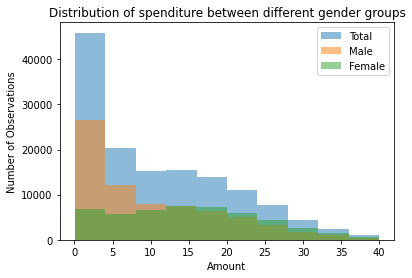

In [85]:
# plot distribution of amounts spends between gender groups
hist_plot(amount_spent, 'amount', 'Distribution of spenditure between different gender groups')

In [86]:
print("Average spent by male customers: {}.".format(amount_spent.loc[amount_spent.gender == 'M'].amount.mean()))

Average spent by male customers: 9.970229317731224.


In [87]:
print("Average spent by female customers: {}.".format(amount_spent.loc[amount_spent.gender == 'F'].amount.mean()))

Average spent by female customers: 15.257489381783861.


Our data frame is too large for scatter plot, therefore we will use only 1000 sampled data points

In [88]:
# create a subsumple of our dataset with 1000 data points
dfSample = amount_spent.sample(1000)

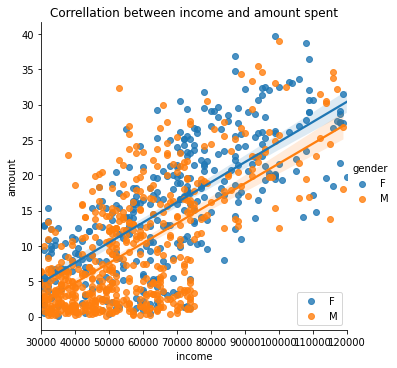

In [89]:
# plot correlation between amounts spent and income
scatter_plot(dfSample.loc[dfSample.gender.isin(["M", 'F'])],'income', 'amount')

In [90]:
# calculate Pearson's correlation
corr, _ = pearsonr(amount_spent.loc[amount_spent.gender == 'F']['income'],
                   amount_spent.loc[amount_spent.gender == 'F']['amount'])
print('Female customers Pearsons correlation: {}'.format(corr))
corr, _ = pearsonr(amount_spent.loc[amount_spent.gender == 'M']['income'],
                   amount_spent.loc[amount_spent.gender == 'M']['amount'])
print('Male customers Pearsons correlation: {}'.format(corr))

Female customers Pearsons correlation: 0.6978041979936807
Male customers Pearsons correlation: 0.6436675274447261


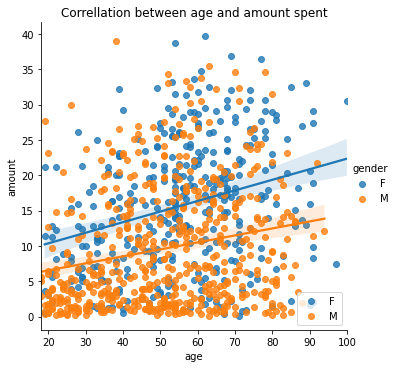

In [91]:
# plot correlation between amounts spent and age
scatter_plot(dfSample.loc[dfSample.gender.isin(["M", 'F'])],'age', 'amount')

In [92]:
# calculate Pearson's correlation on full data set

corr, _ = pearsonr(amount_spent.loc[amount_spent.gender == 'F']['age'], 
                   amount_spent.loc[amount_spent.gender == 'F']['amount'])
print('Female customers Pearsons correlation: {}'.format(corr))
corr, _ = pearsonr(amount_spent.loc[amount_spent.gender == 'M']['age'], 
                   amount_spent.loc[amount_spent.gender == 'M']['amount'])
print('Male customers Pearsons correlation: {}'.format(corr))

Female customers Pearsons correlation: 0.2470281797307271
Male customers Pearsons correlation: 0.24224918963388545


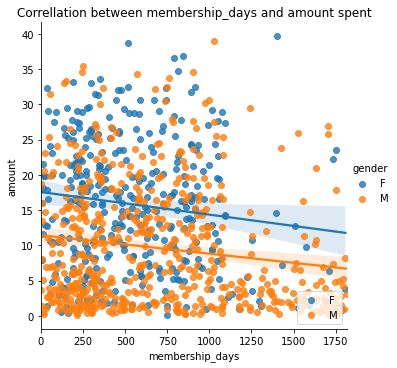

In [93]:
# plot correlation between amounts spent and membership period
scatter_plot(dfSample.loc[dfSample.gender.isin(["M", 'F'])], 'membership_days', 'amount')

In [94]:
# calculate Pearson's correlation
corr, _ = pearsonr(amount_spent.loc[amount_spent.gender == 'F']['membership_days'],
                   amount_spent.loc[amount_spent.gender == 'F']['amount'])
print('Female customers Pearsons correlation: {}'.format(corr))
corr, _ = pearsonr(amount_spent.loc[amount_spent.gender == 'M']['membership_days'],
                   amount_spent.loc[amount_spent.gender == 'M']['amount'])
print('Male customers Pearsons correlation: {}'.format(corr))

Female customers Pearsons correlation: -0.06346622733893575
Male customers Pearsons correlation: -0.08741366856468612


#### Amount spent between  users who are interested in offers and who are not

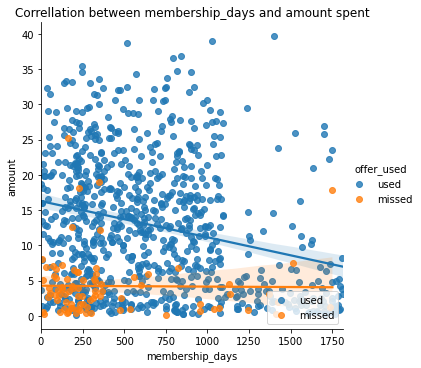

In [95]:
# plot correlation between amounts spent and membership period
scatter_plot(dfSample.loc[dfSample.gender.isin(["M", 'F'])],
             'membership_days','amount',  hue="offer_used")

In [96]:
# calculate Pearson's correlation
corr, _ = pearsonr(amount_spent.loc[amount_spent.person_id.isin(customers_offer_received)]['membership_days'],
                   amount_spent.loc[amount_spent.person_id.isin(customers_offer_received)]['amount'])
print('Offer customers Pearsons correlation: {}'.format(corr))
corr, _ = pearsonr(amount_spent.loc[amount_spent.person_id.isin(customers_offer_missed)]['membership_days'],
                   amount_spent.loc[amount_spent.person_id.isin(customers_offer_missed)]['amount'])
print('No-offer customers Pearsons correlation: {}'.format(corr))

Offer customers Pearsons correlation: -0.07014607222696521
No-offer customers Pearsons correlation: -0.045055350757187834


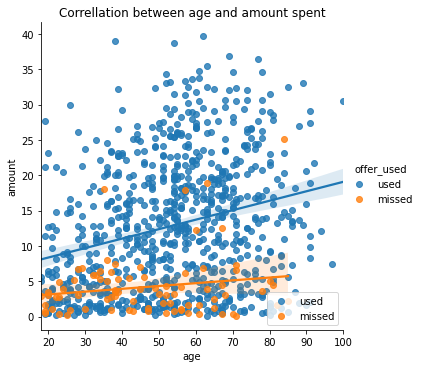

In [97]:
# plot correlation between amounts spent and age
scatter_plot(dfSample.loc[dfSample.gender.isin(["M", 'F'])],
             'age','amount',  hue="offer_used")

In [491]:
# calculate Pearson's correlation
corr, _ = pearsonr(amount_spent.loc[amount_spent.person_id.isin(customers_offer_received)]['age'],
                   amount_spent.loc[amount_spent.person_id.isin(customers_offer_received)]['amount'])
print('Offer customers Pearsons correlation: {}'.format(corr))
corr, _ = pearsonr(amount_spent.loc[amount_spent.person_id.isin(customers_offer_missed)]['age'],
                   amount_spent.loc[amount_spent.person_id.isin(customers_offer_missed)]['amount'])
print('No-offer customers Pearsons correlation: {}'.format(corr))

Offer customers Pearsons correlation: 0.22046084737960184
No-offer customers Pearsons correlation: 0.04208769210810308


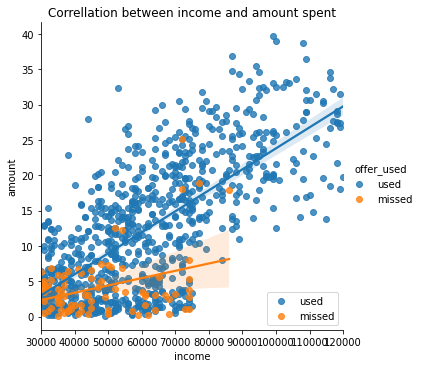

In [98]:
# plot correlation between amounts spent and income
scatter_plot(dfSample.loc[dfSample.gender.isin(["M", 'F'])],
             'income','amount',  hue="offer_used")

In [100]:
# calculate Pearson's correlation
corr, _ = pearsonr(amount_spent.loc[amount_spent.person_id.isin(customers_offer_received)]['income'],
                   amount_spent.loc[amount_spent.person_id.isin(customers_offer_received)]['amount'])
print('Offer customers Pearsons correlation: {}'.format(corr))
corr, _ = pearsonr(amount_spent.loc[amount_spent.person_id.isin(customers_offer_missed)]['income'],
                   amount_spent.loc[amount_spent.person_id.isin(customers_offer_missed)]['amount'])
print('No-offer customers Pearsons correlation: {}'.format(corr))

Offer customers Pearsons correlation: 0.6300093326823648
No-offer customers Pearsons correlation: 0.2632183706810207


<a id="Demographic"></a>
#### Demographic

#### Gender proportion

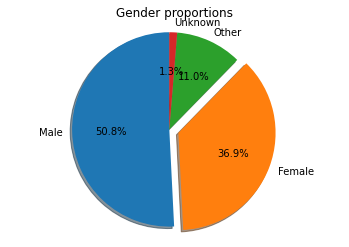

In [101]:
# Gender pie chart
labels = 'Male', 'Female', 'Other', 'Unknown'
sizes = df.gender.value_counts()
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Gender proportions');
plt.show()

#### Income

In [102]:
df.income.describe()

count    306534.000000
mean      64299.872119
std       20039.643261
min       30000.000000
25%       50000.000000
50%       64000.000000
75%       75000.000000
max      120000.000000
Name: income, dtype: float64

In [103]:
df.age.describe()
bins =   [0,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]
labels = ['30000','40000','50000','60000','70000','80000','90000','100000','110000','120000']
m_income = pd.cut(df.loc[df.gender == "M"]['income'], bins,labels=labels).value_counts()
f_income = pd.cut(df.loc[df.gender == "F"]['income'], bins,labels=labels).value_counts()

test = len(bins)-len(labels)
test

1

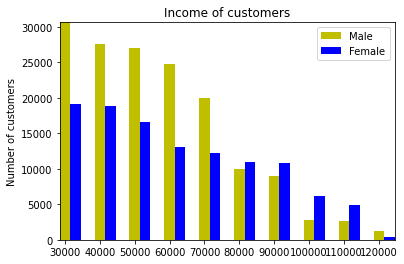

In [104]:
bar_plot(m_income, f_income, 'Income')

#### Age

In [105]:
df.age.describe()

count    306534.000000
mean         54.298942
std          16.607419
min          18.000000
25%          43.000000
50%          57.000000
75%          64.000000
max         101.000000
Name: age, dtype: float64

In [106]:
bins =   [18,25,35, 45, 55, 65,75, 85, 95, 101]
labels = ['18-24', '25-34','35-44', '45-54', '55-64', '65-74','75-84','84-94', '95-101']
m_binned = pd.cut(df.loc[df.gender == "M"]['age'], bins,labels=labels).value_counts()
f_binned = pd.cut(df.loc[df.gender == "F"]['age'], bins,labels=labels).value_counts()



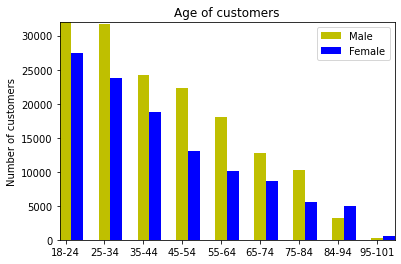

In [107]:
bar_plot(m_binned, f_binned, 'Age')

In [108]:
m_binned

55-64     31954
45-54     31764
35-44     24159
65-74     22264
25-34     18038
18-24     12736
75-84     10189
84-94      3188
95-101      305
Name: age, dtype: int64

#### Membership period

In [109]:
df.membership_days.describe()

count    306534.000000
mean        574.943011
std         421.482784
min           0.000000
25%         242.000000
50%         469.000000
75%         856.000000
max        1823.000000
Name: membership_days, dtype: float64

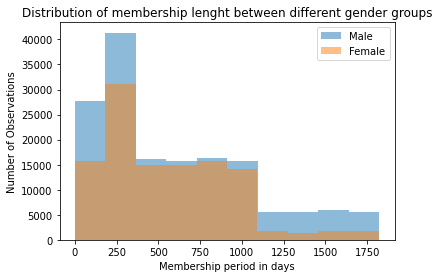

In [110]:
plt.hist(df.loc[df.gender == 'M'].membership_days,  alpha=0.5, label='Male')
plt.hist(df.loc[df.gender == 'F'].membership_days,  alpha=0.5, label='Female')
plt.legend(loc='upper right')
plt.ylabel('Number of Observations')
plt.xlabel('Membership period in days');
plt.title('Distribution of membership lenght between different gender groups');

In [111]:
offer_types= df[['gender','offer_type_bogo','offer_type_discount',
                  'offer_type_informational']].loc[(df.gender.isin(["M", 'F']))&(df.offer_received==1)]


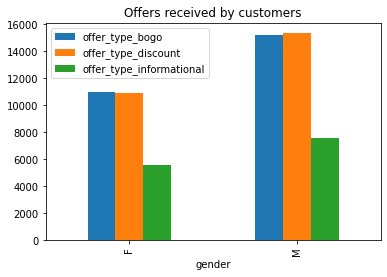

In [112]:
offer_types.groupby('gender').sum().plot.bar(title = "Offers received by customers");

In [113]:
print()
print("Number of different offers received by customers")
print("_"*57)
offer_types.groupby('gender').sum()


Number of different offers received by customers
_________________________________________________________


,offer_type_bogo,offer_type_discount,offer_type_informational
gender,,,
F,10975.0,10943.0,5538.0
M,15208.0,15354.0,7567.0


In [114]:
print()
print("Male:Female ratio")
print("_"*57)
offer_types['gender'].value_counts()/offer_types.shape[0]


Male:Female ratio
_________________________________________________________


M    0.581368
F    0.418632
Name: gender, dtype: float64

In [115]:
print()
print("Proportion of different offers received by customers")
print("_"*57)
offer_types.groupby('gender').sum()/offer_types.groupby('gender').sum().sum()


Proportion of different offers received by customers
_________________________________________________________


,offer_type_bogo,offer_type_discount,offer_type_informational
gender,,,
F,0.419165,0.416131,0.422587
M,0.580835,0.583869,0.577413


<b>Observations</b>
1. Our dataset contains 1700 unique customers, 6 of them never received any offers.
2. 12774 customers completed the offer at least once
3. 4220 never took advantage of an offer
4. All offers have been distributed equally between women and men.
5. Apart from a small proportion of informational offers was sent more to women( less 1%)
6. The data represented by this gender proportion: 59%-male, 40%-email, 11%-other, 1.3%- unknown
7. the mean income is $ 64300
8. Average age 54 years old
9. Half of the  customers have at least 469 days of membership

10. The 99.5% of the customers spend less than $40.

11. 45% of the entire dataset spent between 0.05 and 39.99 dollars.

I have filtered the data for the purpose of analyzing the trend of purchases. So the following points relevant to the customers in this group
12. Female customers tend to spend on average $5 more compare to male clients.
13. There is a strong correlation between income and amount spent. Pearson for female customers is 70 % and 64 for men.
14. Some positive relationship present between age and purchases among all clients (24 Pearson correlation)
15 There is no link between the length of the membership and amount, however, you can notice that people with longer tenure is likely to spend slightly less.
16. However, the situation changes drastically for the customers who use and don't use offers
17. Customers spend more who use offers, and the relation between income and amount increases by 40 %
18. The age-amount correlation goes up by 20%


<a id="Feature_Engineering"></a>
## Feature Engineering

In this part, I want to transform our DataFrame into the customer-offers matrix
1. remove entries for customers who never received any offers
2. rename offers identification codes with labels 0 to 9
3. reliable genders from "M", "F", "O, "U" to numeric labels
4. create a matrix:
  - n-rows with unique customers
  - columns customer's demographic data, plus
  - "total_amount" - the sum of spending after a successful response to an informational offer, and
  - m-offers [0...9] (10 columns), containing sums to the successful response of n-customer to m-offer


In [116]:
# read preprocessed df
df = pd.read_csv('data/data.csv')
df.person_id.nunique()

17000

In [117]:
# customers who received an offer at least once
customers_offer_received = list(df.loc[df['offer_received']==1].person_id.unique())
len(customers_offer_received)

16994

In [118]:
#create a copy data frame only wiht users who receved an offer
offers_df = df.loc[df.person_id.isin(customers_offer_received)]
offers_df.person_id.nunique()

16994

In [119]:
#create an offer-index dictionary and replace with labels in offer_df dataframe
offer_ids = list(offers_df.offer_id.value_counts().index)
offer_dic = {k: v for v, k in enumerate(offer_ids)}
print("Offer-index dictionary")
offer_dic


Offer-index dictionary


{'fafdcd668e3743c1bb461111dcafc2a4': 0,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 1,
 'f19421c1d4aa40978ebb69ca19b0e20d': 2,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 3,
 'ae264e3637204a6fb9bb56bc8210ddfd': 4,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 5,
 '2906b810c7d4411798c6938adc9daaa5': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 8,
 '3f207df678b143eea3cee63160fa8bed': 9}

In [120]:
#replace offer_ids  with labels
offers_df['offer_id'] = offers_df['offer_id'].map(offer_dic)


/home/anna/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [121]:
offers_df.sort_values(['person_id', 'offer_id','transaction_time' ], inplace=True)

/home/anna/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [122]:
offers_df.head()

,person_id,transaction_time,offer_id,offer_received,offer_viewed,offer_completed,transaction,amount,reward_received,difficulty,...,reward,offer_type_bogo,offer_type_discount,offer_type_informational,mobile_channel,social_channel,age,gender,income,membership_days
204340,0009655768c64bdeb2e877511632db8f,21.00,0.0,1,0,0,0,0.0,0.0,10.0,...,2.0,0.0,1.0,0.0,1.0,1.0,33.0,M,72000.0,461
228423,0009655768c64bdeb2e877511632db8f,22.00,0.0,0,0,1,0,0.0,2.0,10.0,...,2.0,0.0,1.0,0.0,1.0,1.0,33.0,M,72000.0,461
233413,0009655768c64bdeb2e877511632db8f,22.50,0.0,0,1,0,0,0.0,0.0,10.0,...,2.0,0.0,1.0,0.0,1.0,1.0,33.0,M,72000.0,461
153401,0009655768c64bdeb2e877511632db8f,17.00,2.0,1,0,0,0,0.0,0.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,33.0,M,72000.0,461
168413,0009655768c64bdeb2e877511632db8f,17.25,2.0,0,0,1,0,0.0,5.0,5.0,...,5.0,1.0,0.0,0.0,1.0,1.0,33.0,M,72000.0,461


In [123]:
def customer_offers_df(offers_df):
    """this function creates user-offers data frame of n-rows,
    unique customers and columns of all offers. 
    If condition of offer met, it adds 1 for n-customer to offer column.
    Conditions:
    1. For non-informational offers:
      - a customer receives the offer
      - views offer before expiration day and after the receipt date
      - completes offer after viewing before the offer expiry
    2. For Informational offers:
     - a customer receives the offer
      - views offer before expiration day and after the receipt date
      - makes any purchase after viewing before offer expiry.
   
    INPUT:
    offers_df-> pandas DF
    OUTPUT:
    df -> pandas DF
    """   
    
    data = []
    customer_ids = offers_df['person_id'].unique()
    
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=len(customer_ids)+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    # itarate through all customers entries
    for ind in range(len(customer_ids)):
        
        # Update the progress bar
        cnter+=1 
        bar.update(cnter)
        
        # data associated with customer offers and demographic
        cust_id = customer_ids[ind]
        customer_data = offers_df[offers_df['person_id']==cust_id][['age','gender','income',
                                                                    'membership_days']].iloc[0]
        cust_offer_data = offers_df[offers_df['person_id']==cust_id][['offer_id','offer_received',
                                            'offer_viewed', 'offer_completed', 'transaction_time', 
                                                        'offer_type_informational','duration']]
         # transactions for this customer 
        cust_transaction_data = offers_df.loc[(offers_df['person_id']==cust_id)&(offers_df['amount']>0)]\
                                                            [['transaction', 'amount','transaction_time']]
        offer_received_data = cust_offer_data[cust_offer_data['offer_received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['offer_completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['offer_viewed'] == 1]
        
        
        entries= []#for all customers
        
        entry = {'person_id': cust_id,'total_amount': 0}#for this customer
        entry.update(customer_data)
        
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            #offer's data
            offer = offer_received_data.iloc[i]
            offer_id = offer['offer_id']
            offer_type = offer['offer_type_informational']
            views_data = offer_viewed_data[offer_viewed_data.offer_id == offer_id]
            completion_data = offer_completed_data[offer_completed_data.offer_id == offer_id]
            duration_days = offer['duration']        
            

            start_time = offer['transaction_time']
            view_time = 0
            end_time = start_time + duration_days
            transaction_total_amount=0
            offer_successful=0
            amount = 0
            
            # check if offer (discount or BOGOF) meets the requirements to be considered successful
            if offer_type==0:
                for v in range(views_data.shape[0]):                
                    if views_data.iloc[v]['transaction_time'] >=start_time and \
                        views_data.iloc[v]['transaction_time']<=end_time:
                        view_time = views_data.iloc[v]['transaction_time']                        
                        
                for c in range(completion_data.shape[0]):
                    if completion_data.iloc[c]['transaction_time'] >=view_time and \
                        view_time >=start_time and \
                        completion_data.iloc[c]['transaction_time']<=end_time:
                        offer_successful=1
                        
            # check if offer (iformational) meets the requirements to be considered successful            
            if offer_type==1:
                for v in range(views_data.shape[0]):                
                    if views_data.iloc[v]['transaction_time'] >=start_time and \
                        views_data.iloc[v]['transaction_time']<=end_time:
                        view_time = views_data.iloc[v]['transaction_time']
                        
                        for t in range(cust_transaction_data.shape[0]):
                            if cust_transaction_data.iloc[t]['transaction_time'] >=view_time and\
                                view_time >= start_time and\
                                cust_transaction_data.iloc[t]['transaction_time']<=end_time:
                                offer_successful+=1
                                amount+=cust_transaction_data.iloc[t]['amount']
            
            #update the entry for this customer           
            if offer_id not in entry:            
                entry[offer_id]=int(offer_successful)
            else:
                entry[offer_id]+=int(offer_successful)
            entry['total_amount']=amount

        # add entry for this customer to the rest of the entries
        entries.append(entry)     
        data.extend(entries)
     
    df = pd.DataFrame(data)
    bar.finish()
    
    return df
    

In [524]:
# create customer_offers dataFarme
data = customer_offers_df(offers_df)

[========================================================================] 100%


In [525]:
#check the customer-offers dataframe
data.head()

,person_id,total_amount,age,gender,income,membership_days,0.0,2.0,6.0,7.0,9.0,1.0,5.0,8.0,3.0,4.0
0,0009655768c64bdeb2e877511632db8f,8.57,33.0,M,72000.0,461,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,00116118485d4dfda04fdbaba9a87b5c,0.00,58.0,U,64000.0,92,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,0.00,40.0,O,57000.0,198,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,NaN,NaN
3,0020c2b971eb4e9188eac86d93036a77,0.00,59.0,F,90000.0,874,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,58.87,24.0,F,60000.0,622,NaN,1.0,NaN,4.0,NaN,1.0,1.0,NaN,NaN,NaN


In [526]:
# Fill Nan values with 0
data.fillna(0, inplace=True);

In [527]:
#rearange columns
data = data[['person_id','age','gender','income','membership_days','total_amount',
             0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]]

In [528]:
label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])

In [529]:
data.head()

,person_id,age,gender,income,membership_days,total_amount,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0009655768c64bdeb2e877511632db8f,33.0,1,72000.0,461,8.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,58.0,3,64000.0,92,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,40.0,2,57000.0,198,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,59.0,0,90000.0,874,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,24.0,0,60000.0,622,58.87,0.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0


In [530]:
data.shape

(16994, 16)

In [531]:
#save preprocesses customer-offers dataframe to csv file
data.to_csv('data/offers_data.csv', index=False)

<a id="Modelling"></a>
## Modelling


For this project I will compare four ML supervised algoriths:
1. Split the data into training and test sets  
  
2. Choose the algorithm

    a.Linear   
  
    b.Non-Lener
  
    c.Desicion Tree algoritms
  
  
- <b>Linear Support Vector Classification </b>
- <b>KNN Classifier </b> 
- <b>Random Forest Classifier</b>
- <b>Decision Tree Regressor </b>


3. Evaluate the model
   Metrics:
   - Mean Squared Error
   - Total average Accuracy
   - Classification Report


In [124]:
# Import useful libraries for our Modeling
# I had some issues with importing libraries, so dah to move import statements here, for convenience
import time
import collections
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [125]:
# read customers_offers dataframe
data = pd.read_csv('data/offers_data.csv')
data.head()

,person_id,age,gender,income,membership_days,total_amount,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0009655768c64bdeb2e877511632db8f,33.0,1,72000.0,461,8.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,58.0,3,64000.0,92,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,40.0,2,57000.0,198,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,59.0,0,90000.0,874,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,24.0,0,60000.0,622,58.87,0.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0


<b>a</b>. We split our data into feature and labels.
 - Age, Gender, Income, Membership in days, and total expenditures after informational offers are our features.
   While offers from 0 to 9 are our labels.

<b>b</b>. and into training and test sets 

- I decided to split in a ratio of 80:20. 

In [126]:
X = data.iloc[:,1:6]
y = data.iloc[:,6:]
X.head()

,age,gender,income,membership_days,total_amount
0,33.0,1,72000.0,461,8.57
1,58.0,3,64000.0,92,0.00
2,40.0,2,57000.0,198,0.00
3,59.0,0,90000.0,874,0.00
4,24.0,0,60000.0,622,58.87


In [127]:
y.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0


In [128]:
# Split out data into test and train data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13595, 5), (13595, 10), (3399, 5), (3399, 10))


Now, our training and test sets are ready, we can start implementing some of the popular Supervised Learning algorithms. 


In [129]:
# Helper function to perform test, train and benchmark
# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html
def classification_model(clf, name, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train):
    """this function performs, train and test of classifier, while performing 
    time benchmarking.
   
    INPUT:
    clf-> scikit-learn classifier
    X_train -> training features set
    y_train -> training labels
    X_test -> testing features set
    y_test -> teesting labels
    name -> name of classifier
    OUTPUT:
    model -> return tuple, containing train time ,test time, mse and average accuracy
    """    
    print('_' * 80)
    print("Training: ")
    print(clf)
    
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    
    print("test time:  %0.3fs" % test_time)
    
    mse = mean_absolute_error(pred, y_test)
    score = (pred == y_test).mean().mean()*100
    
    print("accuracy:   %0.3f" % score)   
    print("Mean Absolute Error: %0.3f" % mse)

    model = (name, train_time, test_time, mse, score)   
    
    return model

In [130]:
# The list with the result of all models' performances 
all_models = []

<a id="LinearSVC"></a>
### Linear Support Vector Classifier

The first is a Linear Support VectorClassifier, I decided to wrap it in the scikit-learn MultiOutputClassifier class to avoid issues with multi-labelling.


In [131]:
# LinearSVC : train, test

all_models.append(classification_model(MultiOutputClassifier(LinearSVC(random_state=1)),
                                       "Linear Support Verctor Classifier"))

________________________________________________________________________________
Training: 
MultiOutputClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                          fit_intercept=True,
                                          intercept_scaling=1,
                                          loss='squared_hinge', max_iter=1000,
                                          multi_class='ovr', penalty='l2',
                                          random_state=1, tol=0.0001,
                                          verbose=0),
                      n_jobs=None)


/home/anna/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/anna/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/anna/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/anna/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/anna/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

train time: 19.797s
test time:  0.003s
accuracy:   60.344
Mean Absolute Error: 0.492


/home/anna/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<a id="KNeighbors"></a>
### K Neighbors Classifier

The second model, we are going to test is K Neighbors Classifier. As with the previous model.  I decided to wrap it in the scikit-learn MultiOutputClassifier class to avoid issues with multi-labelling.


In [132]:
# KNeighborsClassifier : train, test

all_models.append(classification_model(MultiOutputClassifier(KNeighborsClassifier()), 
                                       "K Neighbors Classifier"))

________________________________________________________________________________
Training: 
MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='minkowski',
                                                     metric_params=None,
                                                     n_jobs=None, n_neighbors=5,
                                                     p=2, weights='uniform'),
                      n_jobs=None)
train time: 0.181s
test time:  0.959s
accuracy:   82.533
Mean Absolute Error: 0.219


<a id="RandomForestClassifier"></a>
### Random Forest Classifier

It is a slightly more advanced algorithm and an ensemble learning method for classification. Making a  sharp predicton between different submodels.  I  am expecting the result will be more accurate, even with the default parameters. 


In [133]:
# RandomForestClassifier : train, test
all_models.append(classification_model(MultiOutputClassifier(RandomForestClassifier(random_state=1)), 
                                       "Random Forest"))

________________________________________________________________________________
Training: 
MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
           

And, as it was expected the accuracy improved by roughly half of the per cent. 

<a id="DecisionTreeRegressor"></a>
### Decision Tree Regressor

In [134]:
#KDecision Tree Regressor : train, test
all_models.append(classification_model(DecisionTreeRegressor(random_state=1),
                                      "Decision Tree Regressor"))


________________________________________________________________________________
Training: 
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')
train time: 0.075s
test time:  0.002s
accuracy:   74.166
Mean Absolute Error: 0.325


The result is lower.

### Improvement 

As an improvement, I could consider three possible steps:

- perform a grid search approach to tune parameters
- perform some additional feature engineering
- or, to choose a different algorithm.

#### GridSearch

In [135]:
model = MultiOutputClassifier(RandomForestClassifier(random_state=1))

In [136]:
pprint(model.get_params())

{'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False),
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_

In [137]:
# Create the random grid
random_grid = {'estimator__n_estimators': [400, 500],
               'estimator__max_depth': [10],
               'estimator__warm_start': [True, False]}
pprint(random_grid)

{'estimator__max_depth': [10],
 'estimator__n_estimators': [400, 500],
 'estimator__warm_start': [True, False]}


In [138]:
# Use the random grid to search for best hyperparameters
#Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50,
                               n_jobs= 1,cv = 3, verbose=2, random_state=1)
# Fit the random search model
model_random.fit(X_train, y_train)

/home/anna/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] estimator__warm_start=True, estimator__n_estimators=400, estimator__max_depth=10 
[CV]  estimator__warm_start=True, estimator__n_estimators=400, estimator__max_depth=10, total=  25.4s
[CV] estimator__warm_start=True, estimator__n_estimators=400, estimator__max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.4s remaining:    0.0s


[CV]  estimator__warm_start=True, estimator__n_estimators=400, estimator__max_depth=10, total=  24.6s
[CV] estimator__warm_start=True, estimator__n_estimators=400, estimator__max_depth=10 
[CV]  estimator__warm_start=True, estimator__n_estimators=400, estimator__max_depth=10, total=  24.5s
[CV] estimator__warm_start=False, estimator__n_estimators=400, estimator__max_depth=10 
[CV]  estimator__warm_start=False, estimator__n_estimators=400, estimator__max_depth=10, total=  24.6s
[CV] estimator__warm_start=False, estimator__n_estimators=400, estimator__max_depth=10 
[CV]  estimator__warm_start=False, estimator__n_estimators=400, estimator__max_depth=10, total=  24.5s
[CV] estimator__warm_start=False, estimator__n_estimators=400, estimator__max_depth=10 
[CV]  estimator__warm_start=False, estimator__n_estimators=400, estimator__max_depth=10, total=  24.7s
[CV] estimator__warm_start=True, estimator__n_estimators=500, estimator__max_depth=10 
[CV]  estimator__warm_start=True, estimator__n_es

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  5.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                                    ccp_alpha=0.0,
                                                                                    class_weight=None,
                                                                                    criterion='gini',
                                                                                    max_depth=None,
                                                                                    max_features='auto',
                                                                                    max_leaf_nodes=None,
                                                                                    max_samples=None,
                                                                                    min_impurity_decrease=0.0,
                               

In [139]:
# get the best params
model_random.best_params_

{'estimator__warm_start': True,
 'estimator__n_estimators': 400,
 'estimator__max_depth': 10}

In [140]:
#RF_tuned : train, test
all_models.append(classification_model(MultiOutputClassifier(RandomForestClassifier(warm_start= True, 
                                                    random_state=1,                                  n_estimators=400,
                                                                                    
    
                                                    max_depth=10),
                                                    ),"RF_tuned"))

________________________________________________________________________________
Training: 
MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=10,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
             

Well, it is an improvement of 2% in accuracy. We can try to tune a little bit more with the GridSearch.

In [141]:
#Gridsearch
model_1 = MultiOutputClassifier(RandomForestClassifier(random_state=1))
params = {'estimator__max_depth':[5,7,10],
        'estimator__n_estimators':[300,400,500]}         
cv = GridSearchCV(estimator = model_1,param_grid = params, 
                          cv = 3, n_jobs = 1, verbose = 2)
cv.fit(X_train, y_train)
cv.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] estimator__max_depth=5, estimator__n_estimators=300 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__max_depth=5, estimator__n_estimators=300, total=  11.9s
[CV] estimator__max_depth=5, estimator__n_estimators=300 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


[CV]  estimator__max_depth=5, estimator__n_estimators=300, total=  11.8s
[CV] estimator__max_depth=5, estimator__n_estimators=300 .............
[CV]  estimator__max_depth=5, estimator__n_estimators=300, total=  11.8s
[CV] estimator__max_depth=5, estimator__n_estimators=400 .............
[CV]  estimator__max_depth=5, estimator__n_estimators=400, total=  15.8s
[CV] estimator__max_depth=5, estimator__n_estimators=400 .............
[CV]  estimator__max_depth=5, estimator__n_estimators=400, total=  15.8s
[CV] estimator__max_depth=5, estimator__n_estimators=400 .............
[CV]  estimator__max_depth=5, estimator__n_estimators=400, total=  15.8s
[CV] estimator__max_depth=5, estimator__n_estimators=500 .............
[CV]  estimator__max_depth=5, estimator__n_estimators=500, total=  19.8s
[CV] estimator__max_depth=5, estimator__n_estimators=500 .............
[CV]  estimator__max_depth=5, estimator__n_estimators=500, total=  19.7s
[CV] estimator__max_depth=5, estimator__n_estimators=500 ......

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  9.0min finished


{'estimator__max_depth': 10, 'estimator__n_estimators': 400}

I think we have maximised our performance for this model and any further tuning will not change it massively.

#### Evaluation

We can check if the model performs well.

Unfortunately, this is not a result I was expecting. I can visualize the performance of all models and print metrics. 

In [96]:
# results = [[x[i] for x in all_models] for i in range(5)]
# results

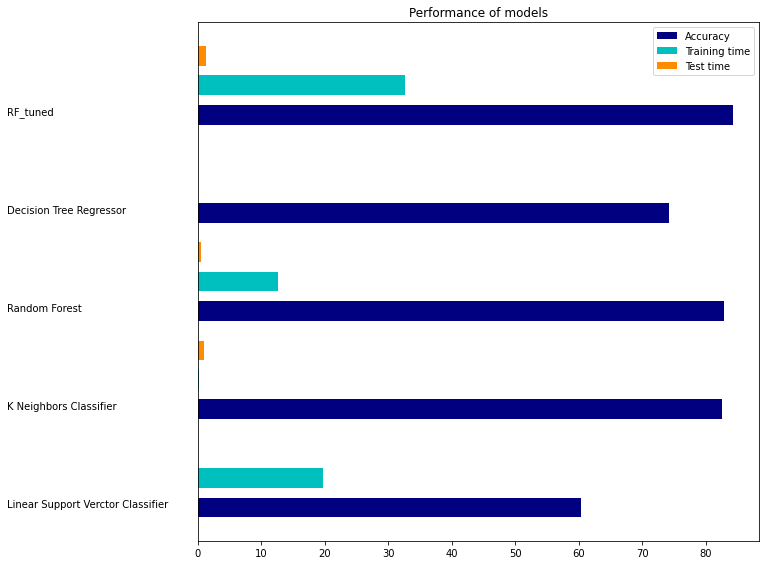

In [146]:
# Display results of our models
# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.
indices = np.arange(len(all_models))

results = [[x[i] for x in all_models] for i in range(5)]

clf_names, training_time, test_time, mse, score, = results
training_time = np.array(training_time) 
test_time = np.array(test_time) 
plt.figure(figsize=(12, 8))
plt.title("Performance of models")
plt.barh(indices, score, .2, label="Accuracy", color='navy')

plt.barh(indices + .3, training_time, .2, label="Training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="Test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-30, i, c)
# 
plt.show()

Finally, I can  print out the classification report for each offer:

In [147]:
#evaluate performance of the model
y_pred = pd.DataFrame(pred, columns = y_test.columns)
for column in y_test.columns:
    print()
    print('Offer: {}'.format(column))
    print(classification_report(y_test[column],y_pred[column]))


Offer: 0.0
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      2559
         1.0       0.00      0.00      0.00       739
         2.0       0.00      0.00      0.00        95
         3.0       0.00      0.00      0.00         6

    accuracy                           0.75      3399
   macro avg       0.19      0.25      0.21      3399
weighted avg       0.57      0.75      0.65      3399


Offer: 1.0
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.87      2642
         1.0       0.00      0.00      0.00       666
         2.0       0.00      0.00      0.00        87
         3.0       0.00      0.00      0.00         4

    accuracy                           0.78      3399
   macro avg       0.19      0.25      0.22      3399
weighted avg       0.60      0.78      0.68      3399


Offer: 2.0
              precision    recall  f1-score   support

         0.0       0.82      1.00      

/home/anna/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id="Collaborative_Filtering"></a>
## User-User Based Collaborative Filtering



Due to the nature of our data the ML models were not able to catch the relationship between multi classes and multi labels. To find a quick solution, I will implement a simple customer based collaborative filtering recommendation approach.

- Normalize features columns
- Compute the similarity of customers based on a dot product
- Make recommendations based on the sum of most used offers among 10 top similar customers.


In [149]:
data.head()

,person_id,age,gender,income,membership_days,total_amount,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0009655768c64bdeb2e877511632db8f,33.0,1,72000.0,461,8.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,58.0,3,64000.0,92,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,40.0,2,57000.0,198,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,59.0,0,90000.0,874,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,24.0,0,60000.0,622,58.87,0.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0


In [150]:
#create a new df without persin_id
data_rec = data.iloc[:,1:]

In [151]:
data_rec.head()

,age,gender,income,membership_days,total_amount,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,33.0,1,72000.0,461,8.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,58.0,3,64000.0,92,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.0,2,57000.0,198,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,59.0,0,90000.0,874,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,0,60000.0,622,58.87,0.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0


In [152]:
#Normilize "age", "income", 
def normalize_series(s):
    """
    Input:
    s_> pd.Series
    Output:
    s-> normilised pd.Series
    """
    return (s - s.min()) / (s.max() - s.min())
data_rec['income'] = normalize_series(data_rec['income'])
data_rec['membership_days'] = normalize_series(data_rec['membership_days'])
data_rec['age'] = normalize_series(data_rec['age'])
data_rec['total_amount'] = normalize_series(data_rec['total_amount'])

In [153]:
data_rec.head()

,age,gender,income,membership_days,total_amount,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0.180723,1,0.466667,0.252880,0.011480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.481928,3,0.377778,0.050466,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.265060,2,0.300000,0.108612,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.493976,0,0.666667,0.479430,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.072289,0,0.333333,0.341196,0.078859,0.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0


In [154]:

def find_similar_users(customer_id, data_rec=data_rec):
    '''
    INPUT:
    customer_id - (int) a user_id
    offers_df - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_customers - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similar_customers = {}
    for customer in data_rec.index:
        similar_customers[customer] = np.dot(data_rec.iloc[customer_id, :5], data_rec.iloc[customer, :5])
    # sort by similarity
    sorted_similar_customers = collections.OrderedDict({k: v for k, v in sorted(similar_customers.items(),
                                                        key=lambda item: item[1], reverse=True)})
    # create list of just the ids
    most_similar_customers= list(sorted_similar_customers.keys())
    # remove the own user's id
    most_similar_customers.remove(customer_id)   
    
    return most_similar_customers # return a list of the users in order from most to least similar


In [155]:
print(find_similar_users(1)[:10])

[15183, 12211, 4290, 12294, 2356, 8406, 16771, 1288, 3783, 13124]


In [156]:
#spot check for user "1" and 10 similar customers
data.loc[data.index.isin(np.append(1,find_similar_users(1)[:10]))]

,person_id,age,gender,income,membership_days,total_amount,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
1,00116118485d4dfda04fdbaba9a87b5c,58.0,3,64000.0,92,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1288,13c47585aa254c2c99abbf1fae4cac33,58.0,3,64000.0,1736,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2356,24ed163d8e0d467fb01eda3d6fd78528,58.0,3,64000.0,1770,3.07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3783,3964c9d017984279866a8496b9cd2156,58.0,3,64000.0,1729,0.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4290,405abb415d4b44379feec2185f49cee3,58.0,3,64000.0,1797,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8406,7e855376e2174402bcf964468f4a71c1,58.0,3,64000.0,1766,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12211,b685bf9de0794b44ba299464a95aa679,58.0,3,64000.0,1811,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
12294,b7dc974d1a5e4790b8e5eea0410efbf2,58.0,3,64000.0,1797,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13124,c4e840f6afb043a99781ce5a55cab241,58.0,3,64000.0,1720,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
15183,e431ebcc6f944c5c9a2d93cbd4a790d7,58.0,3,64000.0,1819,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [157]:
def recomendations(customer_id , data_rec=data_rec, m=10):
    '''
    INPUT:
    customer_id - (int) a user_id
    data_rec - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    m - number of customers to compare with
    
    OUTPUT:
    recs - sorted pd.Series of most recomended offers
    '''
    
    sim_customers  = find_similar_users(customer_id)[:m]
    recs = data_rec.iloc[data_rec.index.isin(sim_customers),
                                  5:].sum().sort_values(ascending = False)
    
    return recs

print(recomendations(1)[:3])

7.0    8.0
9.0    3.0
1.0    2.0
dtype: float64


Lets first decode our offers, we can use the dictionary we created in a previous section and pull the offers data from portfolio dataset. We can create a recommendation data frame.

In [158]:
#print offers dictionary
offer_dic

{'fafdcd668e3743c1bb461111dcafc2a4': 0,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 1,
 'f19421c1d4aa40978ebb69ca19b0e20d': 2,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 3,
 'ae264e3637204a6fb9bb56bc8210ddfd': 4,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 5,
 '2906b810c7d4411798c6938adc9daaa5': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 8,
 '3f207df678b143eea3cee63160fa8bed': 9}

In [161]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [167]:
# Create a recommenadtion data frame
recommend_arr = []

for k, v in offer_dic.items():
   
    id_o = portfolio.loc[portfolio['id'] == k]['id'].item()
    type_o = portfolio.loc[portfolio.id == k].offer_type.item()
    channels = portfolio.loc[portfolio.id == k].channels.item()
    row = {
        
        'offer': float(v),
        'offer_id': id_o,
        'offer_type':type_o,
        'recommended_channels':channels
    }
    recommend_arr.append(row)

     
rec_df = pd.DataFrame(recommend_arr)
rec_df

,offer,offer_id,offer_type,recommended_channels
0,0.0,fafdcd668e3743c1bb461111dcafc2a4,discount,"[web, email, mobile, social]"
1,1.0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,"[web, email, mobile, social]"
2,2.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,"[web, email, mobile, social]"
3,3.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"[web, email, mobile, social]"
4,4.0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,"[email, mobile, social]"
5,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,"[web, email, mobile]"
6,6.0,2906b810c7d4411798c6938adc9daaa5,discount,"[web, email, mobile]"
7,7.0,5a8bc65990b245e5a138643cd4eb9837,informational,"[email, mobile, social]"
8,8.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"[web, email]"
9,9.0,3f207df678b143eea3cee63160fa8bed,informational,"[web, email, mobile]"


In [168]:
# now we can easy retrieve offer's info
def get_offers_info(offers_ids, df=rec_df):
    '''
    INPUT:
    offers_ids - (list) a list of offers ids
    df - (pandas dataframe) with offers
    
    OUTPUT:
    offers_info - dictionary with offers information
    '''
    # Your code here
    offers_info = df[df['offer'].isin(offers_ids)][['offer_id','offer_type','recommended_channels']].to_dict()
    return offers_info 

In [169]:
pprint(get_offers_info([0.0,7.0]))

{'offer_id': {0: 'fafdcd668e3743c1bb461111dcafc2a4',
              7: '5a8bc65990b245e5a138643cd4eb9837'},
 'offer_type': {0: 'discount', 7: 'informational'},
 'recommended_channels': {0: ['web', 'email', 'mobile', 'social'],
                          7: ['email', 'mobile', 'social']}}


In [170]:
def get_customer(customer,data=data):
    '''
    INPUT:
    customer- (list) customer data(age, gender, income, membership_days)
    data -  pandas df conteining customers info and transactions
    OUTPUT:
    customer_id - customer id
    '''
    customer_id = data.loc[(data.age ==customer[0])&(data.gender ==customer[1])\
                              &(data.income ==customer[2])\
                               &(data.membership_days==customer[3])].index[0]
    
    return customer_id

In [172]:
customer  = [58, 3,64000,92]

In [173]:
print(get_customer(customer))

1


In [174]:
#get user reconedations 
def get_recommendations(customer, m=3):
    '''
    INPUT:
    customer- (list) customer data(age, gender, income, membership_days)
  
    m - number of recommendations
    
    OUTPUT:
     rec_dic- sorted dictionary of most recommended offers
    '''
    customer_id = get_customer(customer)
    
    rec_idx = [float(x) for x in list(recomendations(customer_id)[:3].index)]
    rec_dic = get_offers_info(rec_idx)
    return rec_dic

In [175]:
print("Top 3 recomendation for user [58, 3,64000,92]")
print("="*45)
pprint(get_recommendations(customer))

Top 3 recomendation for user [58, 3,64000,92]
{'offer_id': {1: '2298d6c36e964ae4a3e7e9706d1fb8c2',
              7: '5a8bc65990b245e5a138643cd4eb9837',
              9: '3f207df678b143eea3cee63160fa8bed'},
 'offer_type': {1: 'discount', 7: 'informational', 9: 'informational'},
 'recommended_channels': {1: ['web', 'email', 'mobile', 'social'],
                          7: ['email', 'mobile', 'social'],
                          9: ['web', 'email', 'mobile']}}



<a id="Conclusion "></a>
## Conclusion 

1. <b>Problem Formulation</b>

This project contains simulated data that mimics customer behaviour on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offers during certain weeks.

Instead of randomly sending offers to customers, a business can use a more targeted approach and distribute promotions to a more responsive group. 

Each customer can be given a recommendation, based on their demographic information and based on collected data of previous transactions form similar customers.

The example of a solution to this problem could be you collect and input necessary data: 

Input: Customer age: 58, gender: M, income: $64000, length of membership: 3 months
After providing with information, the classifier predicts more promising offers for this customer.

Output: Offer 1, Offer 5, Offer 6
Since we have labelled data it is a supervised task, but because we have 10 classes it is a multi-label classification problem. 


2. <b>Data</b>


This project initially supplemented by 3 JSON format datasets:

- portfolio.json - containing information about offers: duration, type, difficulty and rewards.

- profile.json with customers data: age, gender, income, date of becoming a member.

- transcript.json -  all transactions during the 30 days of the experiment.

In general, the datasets are clean, with no duplicates and only missing values for age, gender and income in 2175 records from profile data. After performing cleaning, renaming, replacing Nun values with mean and one-hot encoding for categorical features, I merged all tree datasets on person_id and offer _id.



3. <b>Data exploration</b>

Exploring the preprocessed and merged dataset, I made the following discoveries:
- Out of 1700 customers, ratio Male: Female  is 58:42
- Female customers tend to spend more, on average £5 per transaction.
- There is some correlation between age, income and amount of customers spend.
- All offers there distributed proportionally between female and male customers. Informational offers were distributed half less comparing to Discount and BOGOF offers. 
-Membership length doesn't make any difference to offer completion and amount spent.
-However, customers, who used offer at least once, willing to spend more.


4. <b>Feature Engineering</b>

In this part of the project, I removed 6 customers who never received any offers, labelled offers ids and gender. 
And finally, created a customer-offers matrix:
- n-rows with unique customers
- columns customer's demographic data, plus
- "total_amount" - the sum of spending after a successful response to an informational offer, and
- m-offers [0...9] (10 columns), containing sums to the successful response of n-customer to m-offer.


5. <b>Modeling</b>

I attempted multi-label and multi-label supervised classification with  four models:

- Linear Support Vector Classification
- K Nearest Neghbors Classifier
- Random Forest Classifier
- Decision Tree Regressor


As a evaluation metrics i employed: 


 - Evaluate the model Metrics:
 - Mean Squared Error
 - Total average Accuracy
 - Classification Report.
 
 
 The highest accuracy I managed to achieve was with Random Forest Classifier. Even after parameters' tuning with GridSearch, 84,22 per cent didn't capture the relationship between features and labels.
 
 
6. <b>customer based collaborative filtering</b> 

To find a quick solution, I implemented to implement a simple customer based collaborative filtering recommendation approach. I computed the similarity of customers based on a dot product and made recommendations based on the sum of most used offers among 10 top similar customers.

7. <b>Future work</b>

Despite some issues with classification I enjoyed working on this project.  As future work, I would like to implement Deep Learning techniques, Unsupervised Learning and more advance recommendation approach.